In [6]:
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [7]:
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [8]:
df = pd.read_csv('spam_emails.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [10]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [11]:
747 / 4825 # Thats data imbalance

0.15481865284974095

In [12]:
df_spam = df[df['Category'] == 'spam']
df_spam.shape

(747, 2)

In [13]:
df_ham = df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [14]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0]) # I pick 747 from my ham category
df_ham_downsampled.shape 

(747, 2)

In [15]:
df_balanced = pd.concat([df_spam, df_ham_downsampled]) # Then I merge both groups using pd.concat
df_balanced.shape

(1494, 2)

In [16]:
df_balanced['Category'].value_counts() # Now I have equal numbers of each group

Category
spam    747
ham     747
Name: count, dtype: int64

In [17]:
df_balanced.sample(5) # I check if my new balanced groups are ok, so I pick few samples

,Category,Message
123,spam,Todays Voda numbers ending 7548 are selected t...
2866,ham,He says hi and to get your ass back to south t...
5492,spam,Marvel Mobile Play the official Ultimate Spide...
3260,spam,Congratulations! Thanks to a good friend U hav...
3527,ham,HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DEA...


In [18]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x : 1 if x == 'spam' else 0) # Now I change Category columns into numbers
df_balanced.sample(5)

,Category,Message,spam
4083,ham,No no. I will check all rooms befor activities,0
2719,spam,18 days to Euro2004 kickoff! U will be kept in...,1
2708,spam,Great NEW Offer - DOUBLE Mins & DOUBLE Txt on ...,1
2583,spam,3 FREE TAROT TEXTS! Find out about your love l...,1
2781,ham,Long after I quit. I get on only like 5 minute...,0


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify = df_balanced['spam'])

In [20]:
X_train.head(5)

67      Urgent UR awarded a complimentary trip to Euro...
650     You have won ?1,000 cash or a ?2,000 prize! To...
4359    Our dating service has been asked 2 contact U ...
258                  Where are you lover ? I need you ...
2128    Tessy..pls do me a favor. Pls convey my birthd...
Name: Message, dtype: object

In [21]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3") # There are ready trained models
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [22]:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output'] # So I supply preprocessed_text into bert_encoder and pooled it 


get_sentence_embedding([
    "500$ discount. hurry up", 
    "John, are you up for a volleybal game tomorrow?" # It will return my two 768 length vectors
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.51327264, -0.8884573 , ..., -0.74748886,
        -0.75314736,  0.91964495],
       [-0.8951768 , -0.49236813, -0.94583243, ..., -0.86087525,
        -0.717367  ,  0.90571344]], dtype=float32)>

In [23]:
e = get_sentence_embedding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"])

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]], [e[1]]) # It must be 2D list | i match banana and grapes and similarity is 0.99, so very close 

array([[0.9911088]], dtype=float32)

In [25]:
cosine_similarity([e[0]], [e[3]]) # Now i match banana and jeff bezos and similarity is 0.84, so not that close | I match it with no context so the difference is not that huge

array([[0.84703815]], dtype=float32)

In [26]:
import tensorflow as tf
from tensorflow import keras

text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = "text") # bert will figure it out what the shape is | data type is string

preprocessed_text = bert_preprocess(text_input)

outputs = bert_encoder(preprocessed_text) # Now I have my 3 bert layers | pooled output have bert encoder 768 size vectors

l = tf.keras.layers.Dropout(0.1, name = 'dropout')(outputs['pooled_output']) # My first NN layer will drop 0.1 of neurons | and input is outputs pooled model

l = tf.keras.layers.Dense(1, activation = 'sigmoid', name = "output")(l) # In function argument i pass what i get from my previous layer, so "l"

model = tf.keras.Model(inputs = [text_input], outputs = [l]) # This is my final model

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [28]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name = 'accuarcy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recal')
]

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = METRICS) # I gona print this METRICS to check how my model is working 

In [29]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
35/35 [==============================] - 153s 4s/step - loss: 0.6375 - accuarcy: 0.6286 - precision: 0.6250 - recal: 0.6429
Epoch 2/10
35/35 [==============================] - 143s 4s/step - loss: 0.5149 - accuarcy: 0.7848 - precision: 0.7736 - recal: 0.8054
Epoch 3/10
35/35 [==============================] - 141s 4s/step - loss: 0.4475 - accuarcy: 0.8411 - precision: 0.8293 - recal: 0.8589
Epoch 4/10
35/35 [==============================] - 141s 4s/step - loss: 0.4102 - accuarcy: 0.8562 - precision: 0.8376 - recal: 0.8839
Epoch 5/10
35/35 [==============================] - 141s 4s/step - loss: 0.3715 - accuarcy: 0.8768 - precision: 0.8663 - recal: 0.8911
Epoch 6/10
35/35 [==============================] - 140s 4s/step - loss: 0.3469 - accuarcy: 0.8848 - precision: 0.8646 - recal: 0.9125
Epoch 7/10
35/35 [==============================] - 140s 4s/step - loss: 0.3311 - accuarcy: 0.8866 - precision: 0.8726 - recal: 0.9054
Epoch 8/10
35/35 [==============================] - 140

In [30]:
model.evaluate(X_test, y_test) # I make my dataset balanced so I can relay on my accuracy

12/12 [==============================] - 48s 4s/step - loss: 0.3187 - accuarcy: 0.8957 - precision: 0.9066 - recal: 0.8824


[0.3186676800251007, 0.8957219123840332, 0.906593382358551, 0.8823529481887817]

In [31]:
y_pred = model.predict(X_test) # Its 2D array
y_pred = y_pred.flatten() # So I flatten it to make it 1D

12/12 [==============================] - 48s 4s/step


In [32]:
import numpy as np

y_pred = np.where(y_pred > 0.5, 1, 0) # If values is greater than 0.5 put 1 if less put 0
y_pred

array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
cm

array([[170,  17],
       [ 22, 165]], dtype=int64)

Text(50.722222222222214, 0.5, 'True')

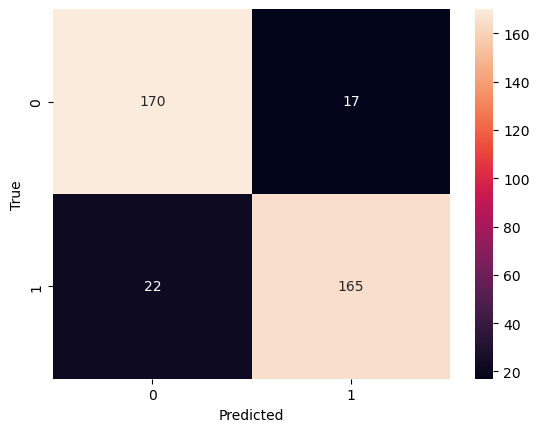

In [34]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('True') # The diagonal are right predicted

In [35]:
print(classification_report(y_test, y_pred)) # Most important is f1 score 

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       187
           1       0.91      0.88      0.89       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



In [36]:
reviews = ['Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews) 


1/1 [==============================] - 2s 2s/step


array([[0.72559696],
       [0.78786594],
       [0.7460981 ],
       [0.14936784],
       [0.07432842]], dtype=float32)

In [40]:
model.save("saved_model/1/")

INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [41]:
model.save("saved_model/2/")

INFO:tensorflow:Assets written to: saved_model/2/assets


INFO:tensorflow:Assets written to: saved_model/2/assets


In [42]:
model.save("saved_model/3/")

INFO:tensorflow:Assets written to: saved_model/3/assets


INFO:tensorflow:Assets written to: saved_model/3/assets
